In [15]:
import os
from pathlib import Path
import pandas as pd
DATAPATH = '../raw_data/2026-01-13/norm_indicators_BTCUSDT.csv'  # Fixed spacing
data = pd.read_csv(DATAPATH, index_col=0, parse_dates=True)  # Fixed spacing
data


,RSI_14,MACD_HIST,BB_POSITION,RET_1,RET_5,RET_15,PRICE_EMA21_DIST,ATR,RET_STD,VOL,VWAP_DIST,BODY_ATR,UPPER_WICK_ATR,LOWER_WICK_ATR
Timestamp,,,,,,,,,,,,,,
2021-02-03 08:00:00,0.241043,0.766984,0.743267,-0.377756,0.564120,1.085109,0.886003,-1.229179,0.436301,-0.324545,-0.385126,-0.304051,0.002224,0.424719
2021-02-03 12:00:00,0.331490,0.873115,0.951573,0.780077,0.431135,1.214219,1.406328,-1.195125,0.383037,-0.116924,0.772595,0.814413,0.062215,0.146598
2021-02-03 16:00:00,0.319736,0.813402,0.809429,-0.156423,0.548618,1.047009,1.168740,-1.349722,0.313561,-0.121001,0.440396,-0.058460,0.355312,0.139496
2021-02-03 20:00:00,0.397526,0.948178,0.958863,0.713091,0.456294,1.191007,1.598814,-1.327871,0.260244,-0.461940,1.474987,0.795460,0.041940,0.138442
2021-02-04 00:00:00,0.373060,0.891754,0.817041,-0.184935,0.446622,1.567032,1.296278,-1.335252,0.108684,-0.046030,-0.518228,-0.117380,0.645205,0.131033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-12 12:00:00,0.120618,0.628817,1.060308,1.827616,0.750075,0.185831,0.174942,-0.243553,-0.752349,0.531128,0.743218,1.206470,0.000000,0.569129
2026-01-12 16:00:00,0.153317,0.768563,1.079844,0.295892,0.633060,0.251728,0.292087,-0.019464,-0.781664,1.094078,0.987219,0.218412,0.523808,0.739383
2026-01-12 20:00:00,0.034096,0.653073,0.429864,-1.056101,-0.634100,-0.022114,-0.210253,0.076271,-0.651300,-0.526775,-0.354414,-0.618494,0.202447,0.391847


Using device: cuda
Dataset size after removing NaN targets: 10829

Target distribution:
 TARGET_CLASS
1    5455
0    5374
Name: count, dtype: int64

Class balance:
 TARGET_CLASS
1    0.50374
0    0.49626
Name: proportion, dtype: float64


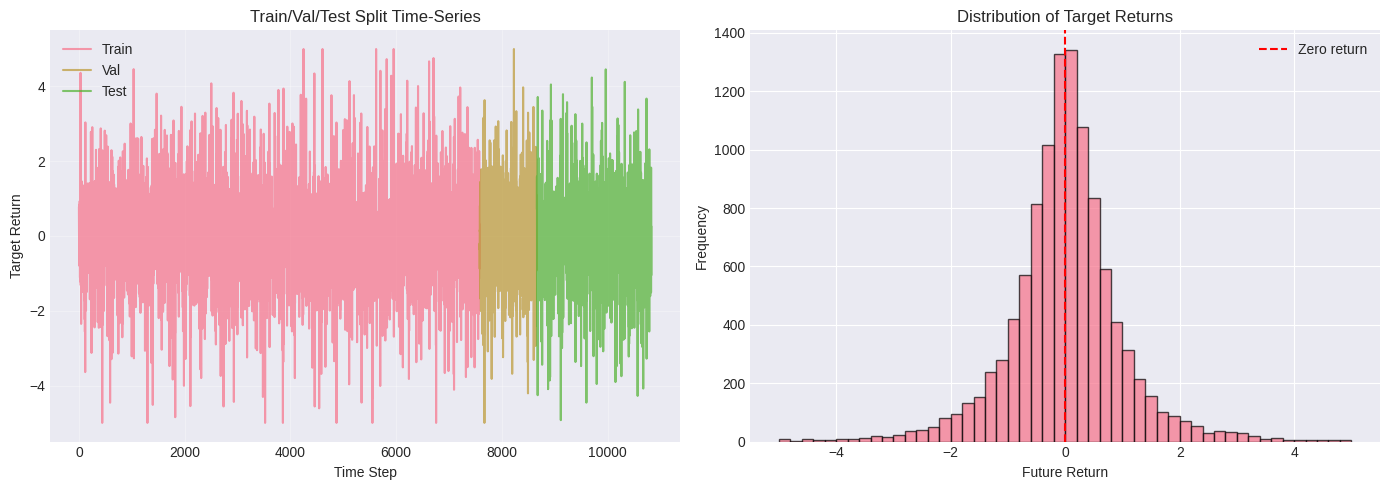

all_features        : 14 features
momentum_only       : 5 features
volatility_only     : 6 features
price_position      : 3 features
volume_based        : 2 features
hybrid_best         : 6 features
minimal             : 3 features
all_features   : train=7580, val=1083, test=2166
momentum_only  : train=7580, val=1083, test=2166
volatility_only: train=7580, val=1083, test=2166
price_position : train=7580, val=1083, test=2166
volume_based   : train=7580, val=1083, test=2166
hybrid_best    : train=7580, val=1083, test=2166
minimal        : train=7580, val=1083, test=2166
Model Architecture:
 PricePredictionNN(
  (network): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

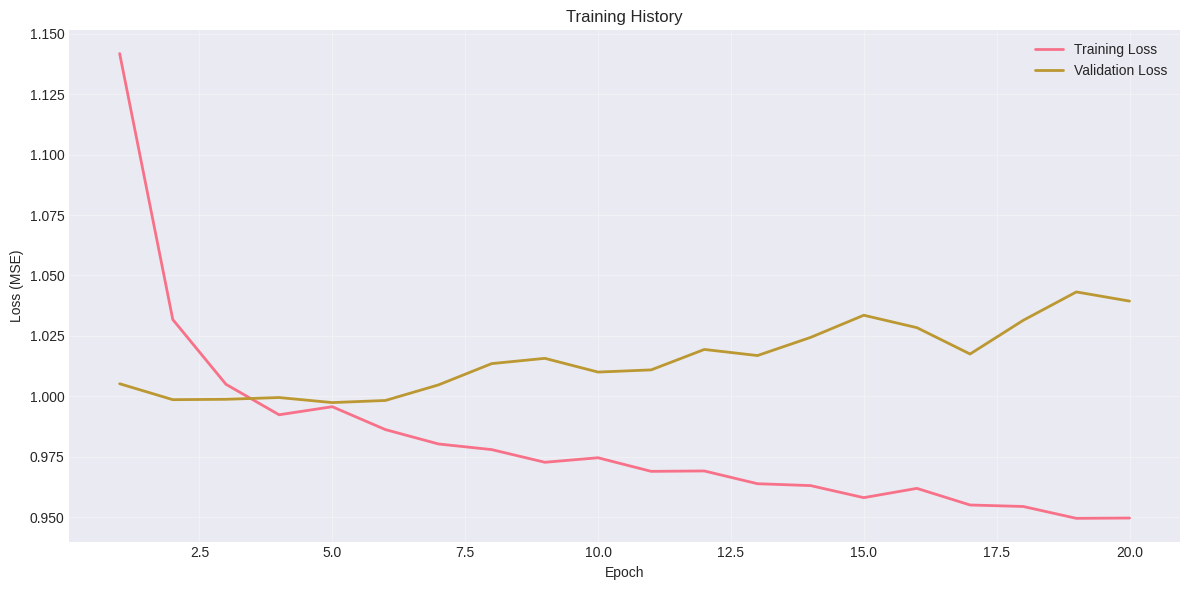

Training history plot saved to training_history.png
TEST SET EVALUATION
Test Loss (MSE): 1.005252
Test RMSE: 1.002622
Directional Accuracy: 52.08%
Random Baseline: 50.00%
Improvement: 2.08%

Training on all_features

Training on momentum_only

Training on volatility_only

FEATURE ABLATION STUDY RESULTS
Feature Set          Num Features    Dir Accuracy    Test Loss      
--------------------------------------------------------------------------------
all_features         14              52.22%          1.0106         
momentum_only        5               53.37%          1.0020         
volatility_only      6               52.77%          1.0070         
--------------------------------------------------------------------------------
Best performing set: momentum_only with 53.37% accuracy


In [2]:
# Cell 1: Imports and setup
import os
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split  # Fixed: added underscore
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Fixed plotting styles
plt.style.use('seaborn-v0_8-darkgrid')  # Fixed: proper style name
sns.set_palette('husl')
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')  # Fixed: f-string, print(f

# Cell 2: Hyperparameters
DATAPATH = Path('../raw_data/2026-01-13/norm_indicators_BTCUSDT.csv')
TARGET_HORIZON = 1  # predict 1 period ahead
HIDDEN_SIZES = [128, 64, 32]  # Fixed list syntax
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
TEST_SIZE = 0.2
VAL_SIZE = 0.1

torch.manual_seed(42)
np.random.seed(42)

# Cell 3: Load and prepare data
data = pd.read_csv(DATAPATH, index_col=0, parse_dates=True)  # Fixed spacing
data.head()  # Fixed: data.

# Cell 4: Target creation
data['TARGET_RET'] = data['RET_1'].shift(-TARGET_HORIZON)  # Fixed spacing/underscores
data['TARGET_CLASS'] = (data['TARGET_RET'] > 0).astype(int)
clean_data = data.dropna(subset=['TARGET_RET']).copy()
print(f"Dataset size after removing NaN targets: {len(clean_data)}")
print("\nTarget distribution:\n", clean_data['TARGET_CLASS'].value_counts())
print("\nClass balance:\n", clean_data['TARGET_CLASS'].value_counts(normalize=True))

# Cell 5: Visualize splits and distributions (fixed plotting)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train/val/test split visualization (fixed timeindex)
y_regression = clean_data['TARGET_RET'].values
n = len(y_regression)
test_start = int(n * (1 - TEST_SIZE))
val_start = int(test_start * (1 - VAL_SIZE / (1 - TEST_SIZE)))
time_index = np.arange(len(y_regression))
axes[0].plot(time_index[:val_start], y_regression[:val_start], label='Train', alpha=0.7)
axes[0].plot(time_index[val_start:test_start], y_regression[val_start:test_start], label='Val', alpha=0.7)
axes[0].plot(time_index[test_start:], y_regression[test_start:], label='Test', alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Target Return')
axes[0].set_title('Train/Val/Test Split Time-Series')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distributions (fixed)
axes[1].hist(clean_data['TARGET_RET'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Future Return')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Target Returns')
axes[1].axvline(0, color='red', linestyle='--', label='Zero return')
axes[1].legend()

plt.tight_layout()
plt.show()

# Cell 6: Feature sets for ablation (new: added)
excluded_cols = ['TARGET_RET', 'TARGET_CLASS']
feature_cols = [col for col in clean_data.columns if col not in excluded_cols]

feature_sets = {
    'all_features': feature_cols,
    'momentum_only': ['RSI_14', 'MACD_HIST', 'RET_1', 'RET_5', 'RET_15'],
    'volatility_only': ['ATR', 'RET_STD', 'BB_POSITION', 'BODY_ATR', 'UPPER_WICK_ATR', 'LOWER_WICK_ATR'],
    'price_position': ['PRICE_EMA21_DIST', 'VWAP_DIST', 'BB_POSITION'],
    'volume_based': ['VOL', 'VWAP_DIST'],
    'hybrid_best': ['RSI_14', 'MACD_HIST', 'ATR', 'VOL', 'VWAP_DIST', 'RET_1'],
    'minimal': ['RET_1', 'ATR', 'VOL']
}

x_datasets = {}
for set_name, feature_list in feature_sets.items():
    x_datasets[set_name] = clean_data[feature_list].values
    print(f"{set_name:<20s}: {len(feature_list)} features")

y_regression = clean_data['TARGET_RET'].values
y_classification = clean_data['TARGET_CLASS'].values

# Cell 7: Time-series split function (new: added)
def create_time_series_splits(X_data, y_data, test_size=0.2, val_size=0.1):
    """Split time series data chronologically."""
    n = len(X_data)
    test_start = int(n * (1 - test_size))
    val_start = int(test_start * (1 - val_size / (1 - test_size)))
    
    x_train = X_data[:val_start]
    x_val = X_data[val_start:test_start]
    x_test = X_data[test_start:]
    y_train = y_data[:val_start]
    y_val = y_data[val_start:test_start]
    y_test = y_data[test_start:]
    
    return x_train, x_val, x_test, y_train, y_val, y_test

# Create splits for all feature sets
splits = {}
for dataset_name, X_data in x_datasets.items():
    x_tr, x_v, x_te, y_tr, y_v, y_te = create_time_series_splits(
        X_data, y_regression, test_size=TEST_SIZE, val_size=VAL_SIZE
    )
    splits[dataset_name] = {
        'x_train': x_tr, 'x_val': x_v, 'x_test': x_te,
        'y_train': y_tr, 'y_val': y_v, 'y_test': y_te
    }
    print(f"{dataset_name:<15s}: train={len(x_tr)}, val={len(x_v)}, test={len(x_te)}")

# Cell 8: Dataset class (new: fixed TimeSeriesDataset → TradingDataset)
class TradingDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Cell 9: Model class (fixed PricePredictionNN, added SimpleNN)
class PricePredictionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(PricePredictionNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class SimpleNN(nn.Module):  # Added for ablation
    def __init__(self, input_size, hidden_sizes, dropout):
        super(SimpleNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Example model creation (using all_features)
input_size = x_datasets['all_features'].shape[1]
model = PricePredictionNN(input_size=input_size).to(device)
print("Model Architecture:\n", model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Cell 10: Train/Val functions (fixed)
def train_epochs(model, train_loader, optimiser, criterion, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # Fixed unsqueeze
        optimiser.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def val_epochs(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Cell 11: DataLoaders example (using all_features split)
data = splits['all_features']
train_dataset = TradingDataset(data['x_train'], data['y_train'])
val_dataset = TradingDataset(data['x_val'], data['y_val'])
test_dataset = TradingDataset(data['x_test'], data['y_test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)  # No shuffle for time series
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

# Cell 12: Full training loop with early stopping (new: complete)
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15
patience_counter = 0

print("Starting training...")
for epoch in range(EPOCHS):
    train_loss = train_epochs(model, train_loader, optimiser, criterion, device)
    val_loss = val_epochs(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Fixed: proper save
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nStopping early at epoch {epoch+1}")
            break

model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Fixed: weights_only=True
print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")

# Cell 13: Plot training history (fixed)
fig, ax = plt.subplots(figsize=(12, 6))
epochs_range = range(1, len(train_losses) + 1)
ax.plot(epochs_range, train_losses, label='Training Loss', linewidth=2)
ax.plot(epochs_range, val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training History')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()
print("Training history plot saved to training_history.png")

# Cell 14: Test evaluation (new: complete with metrics)
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(x_batch).cpu().numpy().flatten()
        all_predictions.extend(predictions)
        all_actuals.extend(y_batch.cpu().numpy())

all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

test_loss = criterion(torch.FloatTensor(all_predictions), torch.FloatTensor(all_actuals)).item()
test_rmse = np.sqrt(test_loss)

pred_direction = (all_predictions > 0).astype(int)
actual_direction = (all_actuals > 0).astype(int)
directional_accuracy = (pred_direction == actual_direction).mean()

print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Random Baseline: 50.00%")
print(f"Improvement: {(directional_accuracy - 0.5)*100:.2f}%")
print("="*60)

# Cell 15: Feature ablation (run for all sets - new: complete loop)
results = {}
for dataset_name in list(splits.keys())[:3]:  # Limit to first 3 for demo
    print("\n" + "="*60)
    print(f"Training on {dataset_name}")
    print("="*60)
    
    data = splits[dataset_name]
    train_dataset = TradingDataset(data['x_train'], data['y_train'])
    val_dataset = TradingDataset(data['x_val'], data['y_val'])
    test_dataset = TradingDataset(data['x_test'], data['y_test'])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    input_size = data['x_train'].shape[1]
    model = SimpleNN(input_size, HIDDEN_SIZES, DROPOUT).to(device)  # Use SimpleNN for ablation
    optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()
    
    # Quick training (20 epochs for demo)
    best_val_loss = float('inf')
    for epoch in range(20):
        train_loss = train_epochs(model, train_loader, optimiser, criterion, device)
        val_loss = val_epochs(model, val_loader, criterion, device)
    
    # Evaluate
    model.eval()
    all_preds = []
    all_acts = []
    with torch.no_grad():
        for x_b, y_b in test_loader:
            x_b = x_b.to(device)
            preds = model(x_b).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_acts.extend(y_b.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_acts = np.array(all_acts)
    test_loss = criterion(torch.FloatTensor(all_preds), torch.FloatTensor(all_acts)).item()
    pred_dir = (all_preds > 0).astype(int)
    act_dir = (all_acts > 0).astype(int)
    dir_acc = (pred_dir == act_dir).mean()
    
    results[dataset_name] = {'test_loss': test_loss, 'directional_accuracy': dir_acc, 'num_features': input_size}

print("\n" + "="*80)
print("FEATURE ABLATION STUDY RESULTS")
print("="*80)
print(f"{'Feature Set':<20} {'Num Features':<15} {'Dir Accuracy':<15} {'Test Loss':<15}")
print("-"*80)
for dataset_name, metrics in results.items():
    print(f"{dataset_name:<20} {metrics['num_features']:<15} {metrics['directional_accuracy']:<15.2%} {metrics['test_loss']:<15.4f}")

best_set = max(results.items(), key=lambda x: x[1]['directional_accuracy'])
print("-"*80)
print(f"Best performing set: {best_set[0]} with {best_set[1]['directional_accuracy']:.2%} accuracy")
print("="*80)
